# Statistical Testing, Time Analysis & Feature Engineering

**This stage focuses on statistical validation of patterns, time-based trend analysis, and creation of engineered features to enhance analytical and predictive capability.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


df = pd.read_csv("data/processed/day3_eda_ready.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,age_group
0,58,Management,Married,Tertiary,No,9.226607,Yes,No,Not_Specified,5,May,261,1,-1,0,No,Middle Age
1,44,Technician,Single,Secondary,No,8.993427,Yes,No,Not_Specified,5,May,151,1,-1,0,No,Adult
2,33,Entrepreneur,Married,Secondary,No,8.990068,Yes,Yes,Not_Specified,5,May,76,1,-1,0,No,Adult
3,47,Blue-Collar,Married,Secondary,No,9.161885,Yes,No,Not_Specified,5,May,92,1,-1,0,No,Middle Age
4,33,Blue-Collar,Single,Secondary,No,8.989943,No,No,Not_Specified,5,May,198,1,-1,0,No,Adult


In [2]:
import sys
!{sys.executable} -m pip install scipy


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
#Hypothesis Testing

#T-Test : Do subscribers have different average balance than non-subscribers?

yes = df[df["y"]=="Yes"]["balance"].replace([np.inf,-np.inf],np.nan).dropna()
no  = df[df["y"]=="No"]["balance"].replace([np.inf,-np.inf],np.nan).dropna()

print(len(yes), len(no))   # sanity check sample size

stats.ttest_ind(yes, no)

5289 39922


TtestResult(statistic=np.float64(15.066307386092065), pvalue=np.float64(3.592692258577828e-51), df=np.float64(45209.0))

**Subscribers and non-subscribers have significantly different average balances (p < 0.05). Balance is an important predictor of subscription.**

In [4]:
#Anova : Does balance differ across job categories?

groups = [
    df[df["job"]==job]["balance"]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    for job in df["job"].unique()
]

stats.f_oneway(*groups)

F_onewayResult(statistic=np.float64(57.018695059782694), pvalue=np.float64(2.4220502345595846e-115))

**Average balances differ significantly across job categories, indicating job type is associated with financial status.**

In [5]:
#Chi_Square Test : Is subscription dependent on education?

table = pd.crosstab(df["education"], df["y"])
stats.chi2_contingency(table)

Chi2ContingencyResult(statistic=np.float64(223.83482285094695), pvalue=np.float64(2.482480175572878e-49), dof=2, expected_freq=array([[ 6049.5371038 ,   801.4628962 ],
       [22127.47778196,  2931.52221804],
       [11744.98511424,  1556.01488576]]))

**Education level is significantly associated with subscription outcome (p < 0.05).**

<Figure size 1000x500 with 0 Axes>

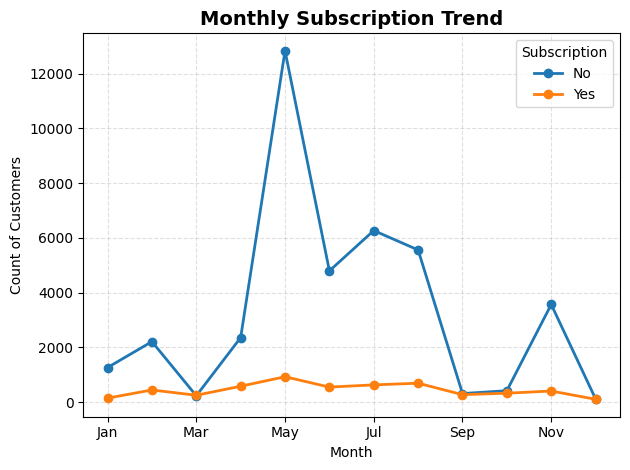

In [6]:
#Time-Based EDA

df["month_num"] = pd.to_datetime(df["month"], format="%b").dt.month

df["date"] = pd.to_datetime(
    df["month_num"].astype(str) + "-" + df["day"].astype(str) + "-2020"
)

plt.figure(figsize=(10,5))

monthly = (
    df.groupby("month")["y"]
    .value_counts()
    .unstack()
    .reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
)

monthly.plot(marker="o", linewidth=2)

plt.title("Monthly Subscription Trend", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Count of Customers")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.savefig("reports/figures/monthly_trend.png", dpi=300)

plt.tight_layout()
plt.show()

**Monthly trends show variation in customer responses, indicating possible time-based effects, though additional yearly data is required to confirm seasonality.**

In [7]:
#Feature Engineering

#1. Age Category
df["age_group"] = pd.cut(df["age"], bins=[18,30,45,60,100],
                         labels=["Young","Adult","Middle Age","Senior"])
#2. Contacted Before?
df["contacted_before"] = df["previous"].apply(lambda x: 1 if x>0 else 0)

#3. Balance Category
df["balance"] = df["balance"].replace([np.inf, -np.inf], np.nan)
df["balance"] = df["balance"].fillna(df["balance"].median())

df["balance_level"] = pd.qcut(df["balance"], 4,
                              labels=["Low","Medium","High","Very High"])

#4. Campaign Intensity
df["campaign_level"] = pd.cut(df["campaign"],
                              bins=[0,2,5,10,100],
                              labels=["Low","Medium","High","Extreme"])

#5. Risk Profile
df["risk_profile"] = np.where(
    (df["loan"]=="yes") & (df["housing"]=="yes"),
    "High Risk","Low Risk"
)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,y,age_group,month_num,date,contacted_before,balance_level,campaign_level,risk_profile
0,58,Management,Married,Tertiary,No,9.226607,Yes,No,Not_Specified,5,...,-1,0,No,Middle Age,5,2020-05-05,0,Very High,Low,Low Risk
1,44,Technician,Single,Secondary,No,8.993427,Yes,No,Not_Specified,5,...,-1,0,No,Adult,5,2020-05-05,0,Low,Low,Low Risk
2,33,Entrepreneur,Married,Secondary,No,8.990068,Yes,Yes,Not_Specified,5,...,-1,0,No,Adult,5,2020-05-05,0,Low,Low,Low Risk
3,47,Blue-Collar,Married,Secondary,No,9.161885,Yes,No,Not_Specified,5,...,-1,0,No,Middle Age,5,2020-05-05,0,Very High,Low,Low Risk
4,33,Blue-Collar,Single,Secondary,No,8.989943,No,No,Not_Specified,5,...,-1,0,No,Adult,5,2020-05-05,0,Low,Low,Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,Technician,Married,Tertiary,No,9.087721,No,No,Cellular,17,...,-1,0,Yes,Middle Age,11,2020-11-17,0,High,Medium,Low Risk
45207,71,Retired,Divorced,Primary,No,9.185023,No,No,Cellular,17,...,-1,0,Yes,Senior,11,2020-11-17,0,Very High,Low,Low Risk
45208,72,Retired,Married,Secondary,No,9.527775,No,No,Cellular,17,...,184,3,Yes,Senior,11,2020-11-17,1,Very High,Medium,Low Risk
45209,57,Blue-Collar,Married,Secondary,No,9.069813,No,No,Telephone,17,...,-1,0,No,Middle Age,11,2020-11-17,0,High,Medium,Low Risk


In [8]:
import os
os.makedirs("data/processed", exist_ok=True)

df.to_csv("data/processed/final_cleaned_day4.csv", index=False)

**New features (age group, balance level, campaign level, risk profile) improved segmentation and modeling readiness.**

## Conclusion — Statistical Testing, Time Analysis & Feature Engineering

**This stage focused on validating patterns statistically, analyzing time trends, and enhancing the dataset with engineered features.**

### **Statistical Test Results**
- **T-Test:** Subscription groups have significantly different average balances.
- **ANOVA:** Customer balance varies across job categories.
- **Chi-Square:** Education level is associated with subscription outcome.

### **Time Analysis Insight**
- Monthly trends show fluctuations in subscriptions, suggesting possible seasonal campaign effects.

### **Feature Engineering Completed**
Created new analytical features:
- Age Group
- Contacted Before Flag
- Balance Level Category
- Campaign Intensity Level
- Risk Profile Segment

### **Dataset Output**
**Final processed dataset exported:**  
`data/processed/final_cleaned_day4.csv`

---

**Conclusion:**  
**Statistical validation confirms meaningful differences between customer segments, and engineered features improve interpretability and modeling readiness.**